# Julie's Notes

- Do the tuples actually need quotation marks?
    - Answer: No
- General questions about the model
    - Answered in person
- Will have to change dataset so that it does not put nan as the source as this causes duplicates, not sure why they would do this
    - Answer: We can just take the first entry of the edge tuple from the "donor_id" column instead of the "source" column
- Had to remove any edges with NaN because it was breaking that, and we wouldn't consider that anyway.
- It works!

In [1]:
# Importing required modules
import xpress as xp
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import time

# Required inputs into the PC-TSP Algorithm:
#      1- List of donor-receipient pairs
#      2- List of altruisitic donors
#      3- List of nodes = donor-receipient pairs + altruisitic donors
#      4- Dictionary of edges with key ("node1","node2") and value is the weight of the edge
#      5- Dictionary of cycles with key (edge1,edge2,edge3,...) and value is the weight of the cycle i.e., 
#         sum of edges in the cycle up to and including length k


# Mini Example
#pairs = ["P1", "P2", "P3"] 
#altruistic_donors = ["NDD1"]
#nodes = pairs + altruistic_donors
#edges = {("NDD1", "P1"): 0.10, 
#         ("NDD1", "P2"): 0.8,
#         ("P1", "P3"): 8, 
#         ("P2", "P3"): 9,
#         ("P3", "P1"): 6,
#         ("P1", "P2"): 6}
#all_cycles = {("P1","P3"): 14}

In [2]:
# Read the Excel file, turn into dataframe
# pool = pd.read_excel('SampleData.xlsx', engine='openpyxl')
pool = pd.read_excel('Data/Dataset25.xlsx', engine='openpyxl')

# Remove unnecessary coloumns
df = pool.drop('dage', axis=1)

In [3]:
# Create list of donor pairs
pairs = list(set(df.loc[pd.isna(df['altruistic']), 'donor_id'].tolist()))

# Create list of altruistic donors
altruistic_donors = list(set(df.loc[df['altruistic'] == 1.0, 'donor_id'].tolist()))

# Create list of nodes
nodes = pairs + altruistic_donors

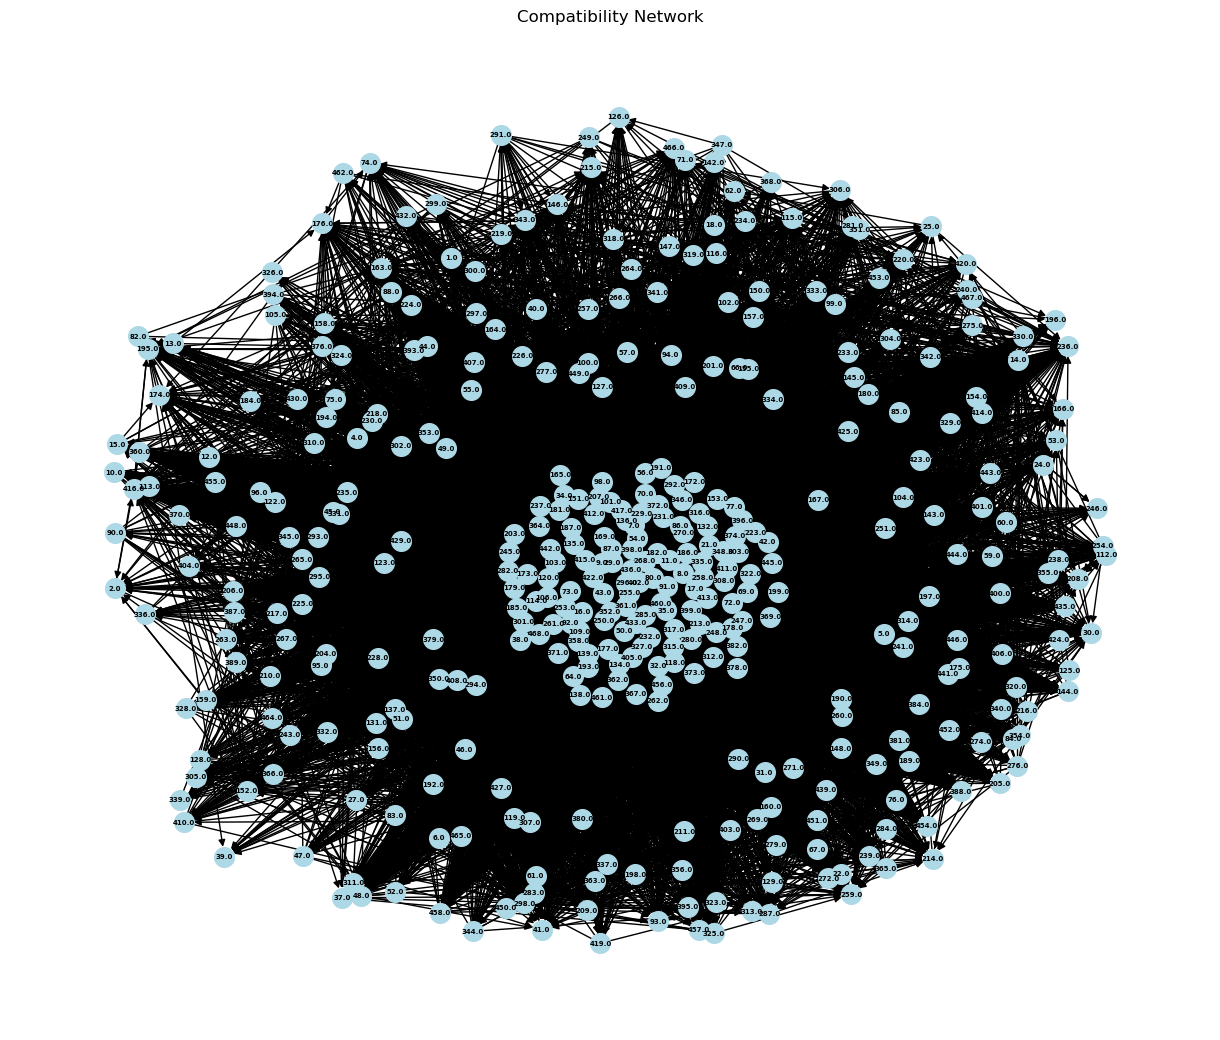

In [4]:
def compatibility_network(df):
    G = nx.DiGraph() 

    if isinstance(df, list):
        pool = pd.DataFrame(df)  
    else:
        pool = df.copy()
    
    # Convert to numeric and handle NaN
    pool['donor_id'] = pd.to_numeric(pool['donor_id'], errors='coerce')
    pool['recipient'] = pd.to_numeric(pool['recipient'], errors='coerce')
    pool['score'] = pd.to_numeric(pool['score'], errors='coerce')

    # Create a list where each donor_id maps to a list of recipients
    matches = []
    for _, row in pool.iterrows():
        source = row['donor_id']
        recipient = row['recipient']
        score = row['score']

        # Ensure valid donor & recipient
        if not np.isnan(source) and not np.isnan(recipient):  
            matches.append((source, recipient, score))
    
    # Add nodes and edges to the graph
    for source, recipient, score in matches:
        G.add_node(source)
        G.add_node(recipient)
        G.add_edge(source, recipient, score=score)
    
    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=1, seed=42) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=200, font_size=5, font_weight='bold', arrows=True)
    
    plt.title("Compatibility Network")
    plt.show()

    return G

G = compatibility_network(df)

In [5]:
# Create edges dictionary with weights
edges = df.dropna(subset=['score']).set_index(['donor_id', 'recipient'])['score'].to_dict()

# Create cycles dictionary
cycles = sorted(nx.simple_cycles(G, length_bound=4))

# Very particular output to make sure we can turn it into a dictionary
with open("output.txt", "w") as f: 
    for cycle in cycles:
        print(",".join(map(str, cycle)), file=f)

# Read the file and convert each line into a tuple
with open("output.txt", "r") as f:
    cycles = [tuple(map(float, line.strip().split(","))) for line in f if line.strip()]

# Convert list of tuples into a dictionary (no weights yet)
cycles_dict = {i: cycle for i, cycle in enumerate(cycles)}

# Function to calculate the sum of weights for a given cycle
def get_cycle_weight(cycle, edges):
    total_weight = 0
    for i in range(len(cycle) - 1):
        edge = (cycle[i], cycle[i + 1])
        if edge in edges:
            total_weight += edges[edge]
        
    # Add the weight for the edge from the last node to the first node
    closing_edge = (cycle[-1], cycle[0])
    if closing_edge in edges:
        total_weight += edges[closing_edge]
        
    return total_weight

# Create dictionary with cycles and weights
all_cycles = {tuple(cycle): get_cycle_weight(cycle, edges) for cycle in cycles_dict.values()}

# Filter out all cycles of length 2 i.e., edges
all_cycles = {key: value for key, value in all_cycles.items() if len(key) != 2}

In [6]:
# Create the graph outside the separation algorithm and feed it in whenever we use it so that it doesn't create it every time
# instead, it just updates the weights i.e., you only create the graph once!

# Add super source 'SUPER' and connect to all NDDs
super_source = "SUPER"
G.add_node(super_source)
for u in altruistic_donors:
    G.add_edge(super_source, u, weight=1)

In [14]:
# I think this is what makes it slow!
print(len(all_cycles))
print(len(edges))

144488
13516


In [11]:
# This cell contains the callbacks and their implementation methods, it must be run before running the model

def separation_algorithm(y, f_i, G=G):
    """
    Implements the separation algorithm for cut-set constraints based on the supplementary information.
    
    >>> Inputs:
    y:                    Dictionary where keys are edge tuples (u, v) and values are their solution values i.e., y[e] gotten via current_sol[0] from above
    f_i:                  Dictionary where keys are nodes and values are the solver solution for f_i[v] gotten via current_sol[2] from above
    G:                    Graph object from Networkx of the current problem.

    >>> Outputs:
    delta_minus_S:       List of edges i.e., (u,v) that are in the named set as per the paper
    v:                   Node at which the constraint is violated for
    """
    
    print(f"Separation algorithm started...")
    start_time = time.time()

    # Add edges with weights from y (solution values)
    # Note: as per the documentation adding an edge that already exists updates the edge data.
    for (u,v), sol_value in y.items():
        G.add_edge(u, v, weight=sol_value)

    print(f"Adding the edges from the given solution took {time.time() - start_time}")
    

    start_time = time.time()
    # Solve the max-flow min-cut problem for each node with f_i[v] > 0
    for v, flow_in in f_i.items():
        if flow_in > 0:
            
            # Compute min-cut using the function from networkx
            cut_value, (Not_S, S) = nx.minimum_cut(G, super_source, v, capacity="weight")
            
            # If the cut weight is less than flow_in, add a violated constraint
            if cut_value < flow_in:

                #print(f"Violated constraint for node {v}: Cut separating {Not_S} and {S}")
 
                
                # Define delta_minus_S in this case
                delta_minus_S = [(u, v) for u, v in G.edges(Not_S) if v in S]

                print(f"Solving the max-flow min-cut problem took {time.time() - start_time}")

                # Return a list that contains the violated constraint's data needed to add the cut into 
                # Xpress using the call back.
                return(delta_minus_S, v)


    print(f"Solving the max-flow min-cut problem took {time.time() - start_time}")

    # Note: This version returns the first violated constraint found; A possible extension is 
    #       to try if its better to return all violated constraints in a single potential solution. 
    return()






def separation_cbpreintsol(prob, data, soltype, cutoff):
    """
    Implements the separation callback when an integer solution is found by heuristics
    or during the branch and bound search, but before it is accepted by the optimizer.
    
    >>> Inputs:
    prob:                    Xpress model object to be passed to the callback function.
    data:                    Data we want to pass into the callback. 
    soltype:                 Type of MIP solution that has been found from 0-3 
    cutoff:                  Current cutoff value for the solution.

    >>> Outputs:
    ifreject:                Binary; 1 if the solution should be rejected and 0 otherwise
    newcutoff:               New cutoff value, to be used by the optimizer if the solution is accepted. 

    Note: The inputs and outputs are required and predetermined in this structure based on Xpress. 
    """
    
    print("##################### CBPREINTSOL EXECUTED ############################")

    start_time = time.time()

    # Initialisze outputs:
    ifreject = 0
    newcutoff = None # Note: this is not being used currently, we will potentially explore it in extensions
    
    # Get LP relaxation solution
    lp_solution = []
    prob.getlpsol(lp_solution, None, None, None)
    
    print(f"Getting the LP relaxation solution took {time.time() - start_time} seconds")


    # Populate values from lp_solution using iteration which should be faster as it is just an O(1) process.
    # Note: we could stop at f_i_temp if it gets too slow. 

    start_time = time.time()

    solution_iter = iter(lp_solution)
    
    for key in y_temp:
        y_temp[key] = next(solution_iter)
    
    for key in z_temp:
        z_temp[key] = next(solution_iter)
    
    for key in f_i_temp:
        f_i_temp[key] = next(solution_iter)
    
    # for key in f_o_temp:
    #     f_o_temp[key] = next(solution_iter)
    
    print(f"Converting the solution into dictionary terms took {time.time() - start_time} seconds")

    # Get the violated constraint data using the separation algorithm from above
    violated_constraint_data = separation_algorithm(y_temp, f_i_temp)

    # Check if there is a violated constraint
    if violated_constraint_data:

        # Reject the solution
        ifreject = 1
        
        # There is a violated constraint so return 1/True i.e., reject this solution
        # Note: From the research I've found the purpose of this callback is to just reject solutions
        #       and not to add constraints to the problem dynamically. This is particularly relevant
        #       for Andrew's part because he'll probably have to do it recursively outside the solver. 
            
    # Otherwise, return 0/False i.e., this solution does not violate a constraint so its good!
    return(ifreject, newcutoff)






def separation_cboptnode(prob, data):
    """
    Implements the separation callback when called during the branch and bound search, after the LP
    relaxation has been solved for the current node, and after any internal cuts and heuristics have been
    applied, but before the optimizer checks if the current node should be branched. 
        
    >>> Inputs:
    prob:                    Xpress model object to be passed to the callback function.
    data:                    Data we want to pass into the callback. 
    
    >>> Outputs:
    feas:                    Feasibility status; If set to a nonzero value the current node is set to infeasible

    Note: The inputs and outputs are required and predetermined in this structure based on Xpress. 
    """

    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!! CBOPTNODE EXECUTED !!!!!!!!!!!!!!!!!!!!!!!!!!!")

    
    # Initialise output 
    feas = 0
    
    # Get LP relaxation solution
    lp_solution = []
    prob.getlpsol(lp_solution, None, None, None)
    
    # Populate values from lp_solution using iteration which should be faster as it is just an O(1) process.
    # Note: we could stop at f_i_temp if it gets too slow. 
    solution_iter = iter(lp_solution)
    
    for key in y_temp:
        y_temp[key] = next(solution_iter)
    
    for key in z_temp:
        z_temp[key] = next(solution_iter)
    
    for key in f_i_temp:
        f_i_temp[key] = next(solution_iter)
    
    # for key in f_o_temp:
    #     f_o_temp[key] = next(solution_iter)

    
    # Get the violated constraint data using the separation algorithm from above
    violated_constraint_data = separation_algorithm(y_temp, f_i_temp)
    
    # If there is a violated constraint add it as a cut
    if violated_constraint_data:
        
        # Unpack the tuple to get the data we want
        delta_minus_S, v = violated_constraint_data  

        # Translate the cut into the presolve index
        colind, rowcoef = [], []
        
        drhsp, status = prob.presolverow(      rowtype = "G", # 'G' for >= constraints
                                               origcolind = [prob.getIndex(y[e]) for e in delta_minus_S] + [prob.getIndex(f_i[v])], # Index values of original variables
                                               origrowcoef = [1] * len(delta_minus_S) + [-1], # Coefficients for original variables
                                               origrhs = 0, # Right-hand side of constraint in original variables
                                               maxcoefs=prob.attributes.cols, # what does this do?
                                               colind=colind, rowcoef=rowcoef # where to output the new ones
                                        ) 
    
        # Now we add the translated cut
        prob.addcuts(
                            cuttype=[1],  # General cut
                            rowtype=['G'],  # Presolved row type are we sure??
                            rhs=[drhsp],  # Presolved RHS
                            start=[0, len(colind)],  # Start indices what does this do? 
                            colind=colind,  # Presolved column indices
                            cutcoef=rowcoef  # Presolved coefficients
                    )

    # Continue solving
    return(feas)

In [18]:
start_time = time.time()

# Define the optimization model
model = xp.problem()

# Decision variables
y = {e: xp.var(vartype=xp.binary, name=f"y_{e}") for e in edges}  # Edge selection
z = {c: xp.var(vartype=xp.binary, name=f"z_{c}") for c in all_cycles}  # Cycle selection
f_i = {v: xp.var(vartype=xp.binary) for v in nodes}  # Flow in decision variable
f_o = {v: xp.var(vartype=xp.binary) for v in nodes}  # Flow out decision variable

# Add decision variables
model.addVariable(list(y.values()) + list(z.values())+ list(f_i.values()) + list(f_o.values()))



# Xpress uses indexing when in callback thats why we need to create a dictionary for the ids. I suspect when you run this on actual data
# you would want to do this in another code cell just so that it isn't repeated every time you solve the model for debugging. 
# e.g., id_vars[("y", ('NDD1', 'P1') )] = 0 i.e., the decision variable to connect nodes NDD1 and P1 is the first decision variable in Xpress.

# Initialize id_vars dictionary and counter to assign sequential values
id_vars = {}
counter = 0

# Populate id_vars with ("y", key) tuples
for key in y.keys():
    id_vars[("y", key)] = counter
    counter += 1
    

# Populate id_vars with ("z", key) tuples
for key in z.keys():
    id_vars[("z", key)] = counter
    counter += 1

# Populate id_vars with ("f_i", key) tuples
for key in f_i.keys():
    id_vars[("f_i", key)] = counter
    counter += 1

# Populate id_vars with ("f_o", key) tuples
for key in f_o.keys():
    id_vars[("f_o", key)] = counter
    counter += 1


# Create temporary storage for the callback solutions to be used:
y_temp = {e: 0 for e in edges}
z_temp = {c: 0 for c in all_cycles} 
f_i_temp = {v: 0 for v in nodes}  
f_o_temp = {v: 0 for v in nodes}  


# Define the objective function which is to maximize sum of weights of selected edges and cycles
model.setObjective(xp.Sum(edges[e] * y[e] for e in edges) + xp.Sum(all_cycles[c] * z[c] for c in all_cycles), sense=xp.maximize)

### Constraints:

# 1. Defining f_i and f_o i.e., the incoming and outgoing kidneys to a node v
for v in nodes:
    model.addConstraint(xp.Sum([y[e] for e in edges if e[1] == v]) == f_i[v])
    model.addConstraint(xp.Sum([y[e] for e in edges if e[0] == v]) == f_o[v])

# 2. Ensure that if a node is in an actived cycle, the associated edges that involve it are turned off
for v in pairs:
    model.addConstraint(f_o[v] + xp.Sum([z[c] for c in all_cycles if v in c]) <= f_i[v] + xp.Sum([z[c] for c in all_cycles if v in c]))
    model.addConstraint(f_i[v] + xp.Sum([z[c] for c in all_cycles if v in c]) <= 1)

# 3. Ensure that altruistic donors donate at most one kidney  
for v in altruistic_donors:
    model.addConstraint(f_o[v] <= 1)



# Add the call back function to detect and add violated constraints during LP relaxation
# model.addcbpreintsol(separation_cbpreintsol, None, 3)  
# model.addcboptnode(separation_cboptnode, None, 1)

model.controls.outputlog = 0 # This just makes it quiet to run

print(f"Setting up the optimization model took {time.time()-start_time} seconds")
start_time = time.time()

# Solve the model
model.solve()

print(f"Solving the model took {time.time()-start_time} seconds to execute.")

# recursive output test:


# Print the output
print("")
print("")
print("")


# print("Optimal Matches:")
# for (u, v), var in y.items():
#     if model.getSolution(var) > 0.5:
#         print(f"{u} donates to {v} with benefit {edges[(u,v)]}")


print(f"Total Benefit: {model.getObjVal()}")
print("")
print("")
print("")


# # Get the current solution
# current_sol = ({e: model.getSolution(y[e]) for e in edges}, {c: model.getSolution(z[c]) for c in all_cycles}, {v: model.getSolution(f_i[v]) for v in nodes})

# # Extract and print solution
# print("Objective Value:", model.getObjVal())
# selected_edges = [e for e in edges if model.getSolution(y[e]) > 0.05]
# selected_cycles = [c for c in all_cycles if model.getSolution(z[c]) > 0.05]
# print("Selected Edges:", selected_edges)
# print("Selected Cycles:", selected_cycles)

Setting up the optimization model took 15.088702201843262 seconds
Solving the model took 4.851895809173584 seconds to execute.



Total Benefit: 22090.0





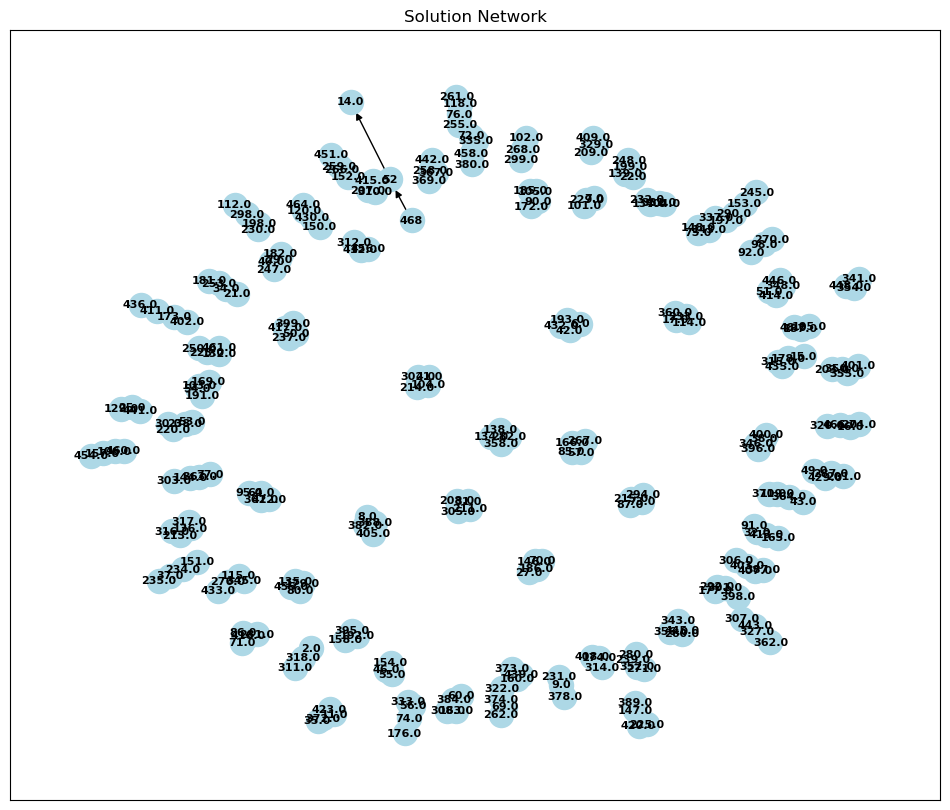

In [ ]:
def solution_network(edges, cycles):
    G = nx.DiGraph() 

    # Add edges
    for e in edges:
        G.add_edge(e[0], e[1])

    # Keep track of which edges are in cycles
    cycle_edges = set()

    # Add cycles
    for c in cycles:
        for i in range(len(c)):
            u, v = c[i], c[(i + 1) % len(c)]
            G.add_edge(u, v)
            cycle_edges.add((u, v))

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)

    non_cycle_edges = [e for e in G.edges() if e not in cycle_edges]
    nx.draw_networkx_edges(G, pos, edgelist=non_cycle_edges, edge_color='black', arrows=True)

    nx.draw_networkx_edges(G, pos, edgelist=list(cycle_edges), edge_color='red', width=2, arrows=True)

    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    plt.title("Solution Network")
    plt.show()

    return G

solution_network(selected_edges, selected_cycles)